In [59]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [60]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")

In [61]:
df.columns

Index(['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income',
       'employment_status', 'location', 'interaction_count', 'lead_score',
       'converted'],
      dtype='object')

In [62]:
#data preparation

In [63]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [64]:
categorical = df.dtypes[df.dtypes == object].index.tolist()
categorical

['lead_source', 'industry', 'employment_status', 'location']

In [65]:
numerical = list(set(df.columns) - set(categorical))

In [66]:
df[numerical] = df[numerical].fillna(0)
df[categorical] = df[categorical].fillna("NaN")

In [67]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [68]:
#split dataset

In [69]:
#Validation framrwork
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df,test_size=0.2,random_state=1)
df_train, df_val = train_test_split(df,test_size=0.25,random_state=1)

len(df), len(df_full_train), len(df_test), len(df_train), len(df_val)

(1462, 1169, 293, 1096, 366)

In [70]:
df_train.reset_index(drop=True, inplace = True)
df_val.reset_index(drop=True, inplace = True)
df_test.reset_index(drop=True, inplace = True)
df_full_train.reset_index(drop=True,inplace=True)

In [71]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values
y_full_train = df_full_train.converted.values

In [16]:
del df_train["converted"]
del df_val["converted"]
del df_test["converted"]
del df_full_train["converted"]

In [17]:
from sklearn.metrics import roc_auc_score, auc, roc_curve

In [18]:
for feature in numerical:
    #print(feature)
    if roc_auc_score(df['converted'],df[feature]) < 0.5:
        print(feature,roc_auc_score(df['converted'],-df[feature]))
    else:
        print(feature,roc_auc_score(df['converted'],df[feature]))

number_of_courses_viewed 0.7608270430582144
converted 1.0
interaction_count 0.7223206403681919
annual_income 0.5426406260848865
lead_score 0.6148050428003213


In [19]:
#Questions 2

from sklearn.feature_extraction import DictVectorizer

In [20]:
train_dict = df_train.to_dict(orient='records')
train_dict[0]

{'lead_source': 'NaN',
 'industry': 'manufacturing',
 'number_of_courses_viewed': 2,
 'annual_income': 0.0,
 'employment_status': 'student',
 'location': 'middle_east',
 'interaction_count': 7,
 'lead_score': 0.82}

In [21]:
dv = DictVectorizer(sparse = False)
X_train = dv.fit_transform(train_dict)
X_train.shape

(1096, 31)

In [22]:
from sklearn.linear_model import LogisticRegression

In [23]:

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [24]:
val_dict = df_val.to_dict(orient= "records")

X_val = dv.transform(val_dict)
X_val.shape

(366, 31)

In [25]:
y_pred = model.predict_proba(X_val)[:,1]

In [26]:
roc_auc_score(y_val,y_pred)

0.8104596394347897

In [28]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        tp = ((y_pred >= t) & (y_val == 1)).sum()
        fp = ((y_pred >= t) & (y_val == 0)).sum()
        fn = ((y_pred < t) & (y_val == 1)).sum()
        tn = ((y_pred < t) & (y_val == 0)).sum()

        scores.append((t, tp, fp, fn, tn))

    df_scores = pd.DataFrame(scores)
    df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [29]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

In [30]:

df_scores = tpr_fpr_dataframe(y_val, y_pred)

In [32]:
auc(fpr, tpr)

0.8104596394347897

In [40]:
#Question 3

true_positive = ((y_pred >= 0.5) & (y_val == 1)).sum()
false_positive = ((y_pred >= 0.5) & (y_val == 0)).sum()
false_negative = ((y_pred < 0.5) & (y_val == 1)).sum()
true_negative = ((y_pred < 0.5) & (y_val == 0)).sum()

In [41]:
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
precision, recall

(np.float64(0.7456445993031359), np.float64(0.9106382978723404))

In [42]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds: #B
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    scores.append((t, tp, fp, fn, tn))

df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

In [43]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,235,131,0,0
10,0.1,235,131,0,0
20,0.2,235,131,0,0
30,0.3,233,125,2,6
40,0.4,229,101,6,30
50,0.5,214,73,21,58
60,0.6,183,39,52,92
70,0.7,149,27,86,104
80,0.8,89,8,146,123
90,0.9,21,0,214,131


In [49]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
from sklearn.metrics import precision_score, recall_score

In [50]:
scores = []

thresholds = np.linspace(0, 1, 101)

for threshold in thresholds:
    precision = precision_score(y_val, y_pred > threshold, zero_division=np.nan)
    recall = recall_score(y_val, y_pred > threshold, zero_division=np.nan)
    scores.append((threshold, precision, recall))


columns = ["threshold", "precision", "recall"]
df_scores = pd.DataFrame(scores, columns=columns)

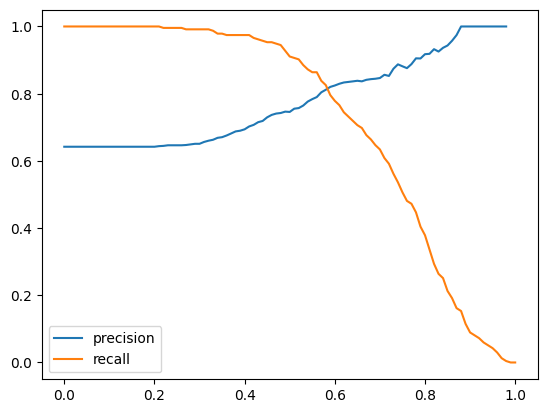

In [51]:
plt.plot(df_scores.threshold, df_scores.precision, label='precision')
plt.plot(df_scores.threshold, df_scores.recall, label='recall')
plt.legend()

In [52]:
from sklearn.metrics import f1_score

In [78]:
thresholds = [ 
0.14,
0.34,
0.54,
0.74]

f1 = []

for threshold in thresholds:
    f1 = f1_score(y_val, y_pred > threshold, zero_division=np.nan)
    #f1_scores.append(f1)
    print(f1)
#df_scores["f1"] = f1_scores

0.7573333333333333
0.7734806629834254
0.8421052631578947
0.6785714285714286


In [54]:
df_scores.loc[df_scores['f1'].idxmax()]

threshold    0.470000
precision    0.740864
recall       0.948936
f1           0.832090
Name: 47, dtype: float64

In [55]:
from sklearn.model_selection import KFold

In [73]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    del df_train['converted']
    del df_val['converted']

    #dv, model = train(df_train, y_train)
    train_dict = df_train.to_dict(orient='records')
    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(train_dict)
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train,y_train)
    
    #y_pred = predict(df_val, dv, model)
    val_dict = df_val.to_dict(orient= "records")
    X_val = dv.transform(val_dict)

    y_pred = model.predict_proba(X_val)[:,1]
    

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

round(np.std(scores).item(), 3)

0.036

In [81]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for C in [0.000001, 0.001, 1]:
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.converted.values
        y_val = df_val.converted.values
    
        del df_train['converted']
        del df_val['converted']
    
        #dv, model = train(df_train, y_train)
        train_dict = df_train.to_dict(orient='records')
        dv = DictVectorizer(sparse = False)
        X_train = dv.fit_transform(train_dict)
        model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
        model.fit(X_train,y_train)
        
        #y_pred = predict(df_val, dv, model)
        val_dict = df_val.to_dict(orient= "records")
        X_val = dv.transform(val_dict)
    
        y_pred = model.predict_proba(X_val)[:,1]
        
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print(C, ":\t", round(np.mean(scores), 3), " +- ",  round(np.std(scores), 3))

1e-06 :	 0.822  +-  0.036
0.001 :	 0.822  +-  0.036
1 :	 0.822  +-  0.036
